PCA

Detected Delimiter: ,
DataFrame Shape: (83, 43)
Index(['Mouse', 'Strain', 'Genotype', 'OFT - Total Distance moved (cm)',
       'OFT - Mean Velocity (cm/s)', 'OFT - Frequency Border Zone',
       'OFT - Total Time in Border Zone (sec)',
       'OFT - Latency to First Enter Border Zone (sec)',
       'OFT - Frequency Corner Zone', 'OFT - Total Time in Corner Zone (sec)',
       'OFT - Latency to First Enter Corner Zone (sec)',
       'OFT - Frequency Center Field',
       'OFT - Total Time in Center Field (sec)',
       'OFT - Latency to First Enter Center Field (sec)',
       'OFT - Total Time Moving (sec)', 'OFT - Total Time Not Moving (sec)',
       'OFT - Circling Clockwise Body Axis Rotations',
       'OFT -Circling Counter Clockwise Body Axis Rotation',
       'OFT - total Body Axis Rotation ', 'OFT - Frequency of Rearing',
       'OFT - Total Time of Rearing (sec)', 'OFT - Time per Rearing (sec)',
       'OFT - Latency to First Rearing (sec)', 'OFT - Frequency Grooming',
       '

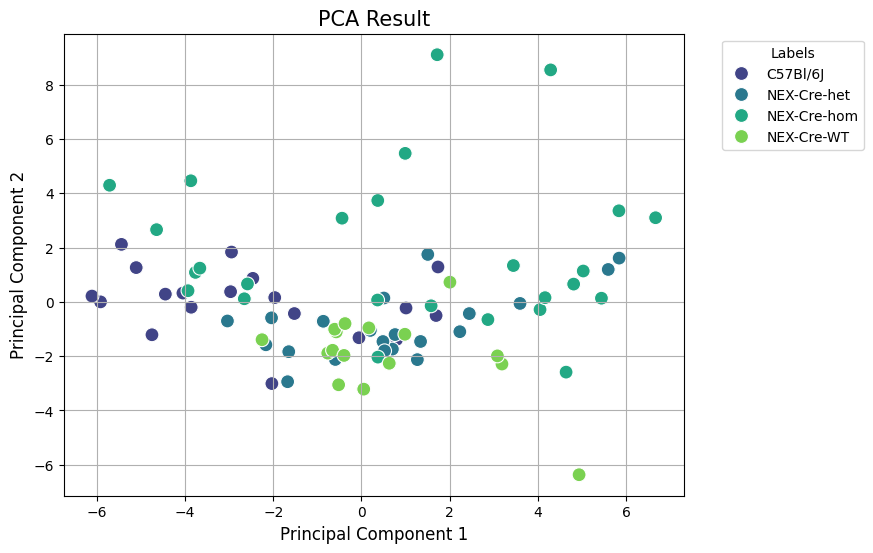

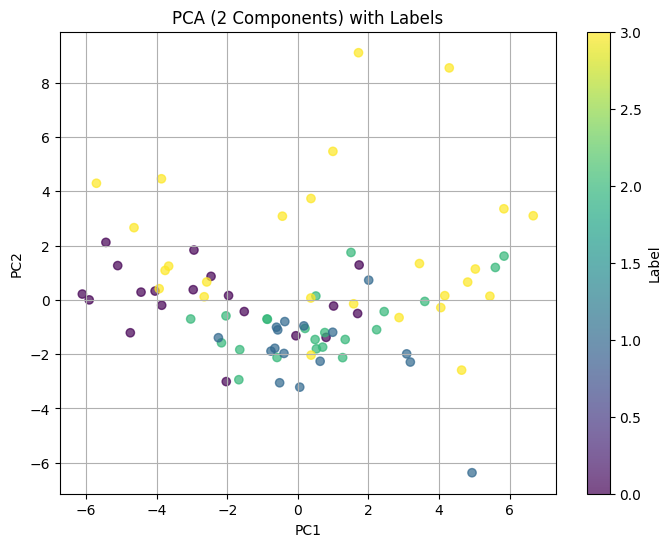

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the cleaned CSV file
file_path = "/Users/mass/Documents/Dokumente - mass MacBook Air/W2-Bremen/Github/PCA/endlich.csv"

# Robust CSV loading with automatic delimiter detection
try:
    # Automatic delimiter detection
    with open(file_path, 'r') as file:
        sample = file.read(1024)
        delimiter = ',' if ',' in sample else ';' if ';' in sample else '\t'

    # Load the CSV with the detected delimiter
    df = pd.read_csv(file_path, delimiter=delimiter, engine='python', on_bad_lines='skip')
    print(f"Detected Delimiter: {delimiter}")
    print(f"DataFrame Shape: {df.shape}")
    print(df.columns)
except Exception as e:
    print(f"Error reading CSV file: {str(e)}")

# Selecting numeric columns for PCA (automatically)
df_selected = df.select_dtypes(include=[np.number])
print(f"Selected Columns for PCA: {df_selected.columns}")

# Standardizing the data (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_selected)

# Perform PCA
pca = PCA(n_components=2)  # Set number of components to 2 for 2D visualization
pca_result = pca.fit_transform(X_scaled)

# Convert PCA result to DataFrame for easier plotting
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# Extract labels from the 3rd column (index 2) of the DataFrame (Adjust if needed)
if df.shape[1] > 2:  # Ensure there are enough columns
    labels = df.iloc[:, 2]  # 3rd column as label (index 2)
else:
    labels = pd.Series(['Unknown'] * len(df))  # Fallback if column doesn't exist

# Add the label column to the DataFrame for coloring
pca_df['label'] = labels.astype(str)  # Ensure labels are strings

# Plotting the PCA results with color based on labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=100, hue='label', palette='viridis')
plt.title('PCA Result', fontsize=15)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(True)
plt.legend(title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("mein_plot.svg", format="svg")
plt.show()

# Scatter plot with color based on the label (with color bar)
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], 
            c=pca_df['label'].astype('category').cat.codes, 
            cmap='viridis', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA (2 Components) with Labels')
plt.colorbar(label='Label')  # Color bar for label
plt.grid(True)
plt.savefig("plot-PCA.svg", format="svg")
plt.show()


In [10]:
print(f"Explained variance ratio by PC1: {pca.explained_variance_ratio_[0]:.2f}")
print(f"Explained variance ratio by PC2: {pca.explained_variance_ratio_[1]:.2f}")
print(f"Total variance explained by PC1 and PC2: {np.sum(pca.explained_variance_ratio_[:2]):.2f}")


Explained variance ratio by PC1: 0.24
Explained variance ratio by PC2: 0.14
Total variance explained by PC1 and PC2: 0.38


In [11]:
from sklearn.metrics import silhouette_score
silhouette = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {silhouette:.2f}")


Silhouette Score: -0.03


t-SNE

(83, 2)


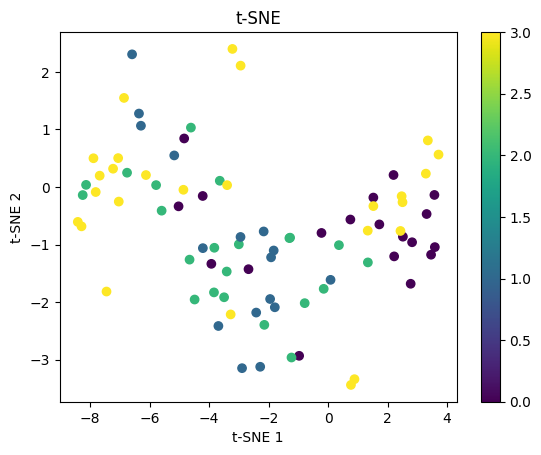

Silhouette Score: -0.0649
Trustworthiness: 0.8530


In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
import numpy as np

# Check if pca_result is defined and has valid data
# Ensure pca_result is a 2D array with valid numerical data
print(pca_result.shape)  # This will output the shape of the PCA data (ensure it's not empty)

# Assuming labels are in the third column of df
labels = df.iloc[:, 2]  # 3rd column, index 2 in Python (0-indexed)

# Encode the labels
le = LabelEncoder()
y_labels_encoded = le.fit_transform(labels)

# Step 1: Initialize and fit t-SNE
tsne = TSNE(n_components=2, random_state=42)  # For 2D plot, use n_components=2
X_tsne = tsne.fit_transform(pca_result)  # Use the PCA result (or scaled data)

# Step 2: Plot the t-SNE results, with points colored by their class labels
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_labels_encoded, cmap='viridis')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE')
plt.colorbar()  # Show color scale for class labels

# Save the figure as SVG using plt.savefig()
plt.savefig("t-SNE.svg", format="svg", bbox_inches="tight")

# Optionally show the plot (useful for interactive environments)
plt.show()

# Step 3: Silhouette Score
silhouette_avg = silhouette_score(pca_result, y_labels_encoded)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Step 4: Trustworthiness Calculation
def trustworthiness(X, X_tsne, n_neighbors=5):
    # Compute the KNN graph of the original data and the t-SNE embedded data
    knn_graph_original = kneighbors_graph(X, n_neighbors=n_neighbors, mode='connectivity', include_self=True)
    knn_graph_tsne = kneighbors_graph(X_tsne, n_neighbors=n_neighbors, mode='connectivity', include_self=True)

    # Compute the trustworthiness score based on nearest neighbor preservation
    trust = np.sum(np.logical_and(knn_graph_original.toarray() == 1, knn_graph_tsne.toarray() == 1)) / np.sum(knn_graph_original.toarray() == 1)
    return trust

# Step 5: Calculate Trustworthiness
trust_score = trustworthiness(pca_result, X_tsne)
print(f"Trustworthiness: {trust_score:.4f}")


SVM and SHAP

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from shap import KernelExplainer
import shap

def svm_cv_with_cpu_shap_and_svg(df, target_column, model_params, n_splits=5):
    # data preparation
    df.columns = df.columns.str.strip()
    y = df[target_column]
    X = df.drop(columns=[target_column]).select_dtypes(include='number').dropna()
    y = y.loc[X.index]
    feature_names = X.columns

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    class_labels = sorted(y.unique())
    all_cm = np.zeros((len(class_labels), len(class_labels)), dtype=int)
    all_acc, all_f1 = [], []
    train_accs, val_accs = [], []  # ✅ 

    # making a folder for figure savings
    os.makedirs("shap_svgs", exist_ok=True)

    for fold, (train_idx, test_idx) in enumerate(cv.split(X_scaled, y)):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = SVC(**model_params, probability=True)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = np.mean(y_pred == y_test)
        f1 = classification_report(y_test, y_pred, output_dict=True, zero_division=0)['weighted avg']['f1-score']
        all_acc.append(acc)
        all_f1.append(f1)

        # Training-/Validation
        train_accs.append(model.score(X_train, y_train))
        val_accs.append(model.score(X_test, y_test))

        cm = confusion_matrix(y_test, y_pred, labels=class_labels)
        all_cm += cm

        print(f"\n✅ Fold {fold+1}: Accuracy: {acc:.3f}, F1: {f1:.3f}")
        print("Confusion Matrix:")
        print(cm)

        #  SHAP last fold only
        if fold == n_splits - 1:
            print("\n🔍 SHAP-Analyse (nur letzter Fold)...")
            X_train_df = pd.DataFrame(X_train[:30], columns=feature_names)
            X_test_df = pd.DataFrame(X_test[:30], columns=feature_names)

            for class_index, class_name in enumerate(model.classes_):
                print(f"\n📈 SHAP Summary für Klasse '{class_name}'")
                explainer = KernelExplainer(lambda x: model.predict_proba(x)[:, class_index], X_train_df)
                shap_values = explainer.shap_values(X_test_df)

                try:
                    shap.summary_plot(
                        shap_values,
                        X_test_df,
                        feature_names=feature_names.tolist(),
                        show=False
                    )

                    fig = plt.gcf()
                    safe_name = str(class_name).replace(" ", "_").replace("/", "-")
                    filepath = os.path.join("shap_svgs", f"shap_summary_{safe_name}.svg")
                    fig.savefig(filepath, format="svg", bbox_inches="tight")
                    print(f"✅ gespeichert: {filepath}")
                    plt.close(fig)

                except Exception as e:
                    print(f"❌ Fehler beim Speichern von SHAP für Klasse '{class_name}': {e}")

    # result CrossVal
    print("\n📊 Durchschnittliche Accuracy:", np.mean(all_acc))
    print("📊 Durchschnittlicher F1 Score:", np.mean(all_f1))
    print("\n🧮 Aggregierte Confusion Matrix:\n", all_cm)

    plt.figure(figsize=(6, 4))
    sns.heatmap(all_cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Aggregierte Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # final model all data
    print("\n📦 Trainiere finales Modell auf gesamten Daten...")
    final_model = SVC(**model_params, probability=True)
    final_model.fit(X_scaled, y)
    y_pred_full = final_model.predict(X_scaled)

    cm_full = confusion_matrix(y, y_pred_full, labels=class_labels)
    print("\n📈 Confusion Matrix (gesamter Datensatz):\n", cm_full)
    print("\n📄 Klassifikationsbericht (gesamter Datensatz):")
    print(classification_report(y, y_pred_full))

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix (Gesamtdaten)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # retunr data
    return final_model, y, X_scaled, feature_names, train_accs, val_accs, X_train_df, X_test_df


Execution


✅ Fold 1: Accuracy: 0.529, F1: 0.465
Confusion Matrix:
[[1 0 3 0]
 [0 0 3 0]
 [0 0 3 2]
 [0 0 0 5]]

✅ Fold 2: Accuracy: 0.647, F1: 0.604
Confusion Matrix:
[[3 0 1 0]
 [0 0 3 0]
 [0 0 4 0]
 [1 0 1 4]]

✅ Fold 3: Accuracy: 0.706, F1: 0.690
Confusion Matrix:
[[2 0 2 0]
 [0 1 3 0]
 [0 0 4 0]
 [0 0 0 5]]

✅ Fold 4: Accuracy: 0.688, F1: 0.650
Confusion Matrix:
[[4 0 0 0]
 [0 0 2 1]
 [0 1 3 0]
 [0 0 1 4]]

✅ Fold 5: Accuracy: 0.688, F1: 0.615
Confusion Matrix:
[[3 0 0 0]
 [0 0 3 0]
 [1 0 3 1]
 [0 0 0 5]]

🔍 SHAP-Analyse (nur letzter Fold)...

📈 SHAP Summary für Klasse 'C57Bl/6J'


  0%|          | 0/16 [00:00<?, ?it/s]

✅ gespeichert: shap_svgs/shap_summary_C57Bl-6J.svg

📈 SHAP Summary für Klasse 'NEX-Cre-WT'


  0%|          | 0/16 [00:00<?, ?it/s]

✅ gespeichert: shap_svgs/shap_summary_NEX-Cre-WT.svg

📈 SHAP Summary für Klasse 'NEX-Cre-het'


  0%|          | 0/16 [00:00<?, ?it/s]

✅ gespeichert: shap_svgs/shap_summary_NEX-Cre-het.svg

📈 SHAP Summary für Klasse 'NEX-Cre-hom'


  0%|          | 0/16 [00:00<?, ?it/s]

✅ gespeichert: shap_svgs/shap_summary_NEX-Cre-hom.svg

📊 Durchschnittliche Accuracy: 0.6514705882352941
📊 Durchschnittlicher F1 Score: 0.6048080351021528

🧮 Aggregierte Confusion Matrix:
 [[13  0  6  0]
 [ 0  1 14  1]
 [ 1  1 17  3]
 [ 1  0  2 23]]


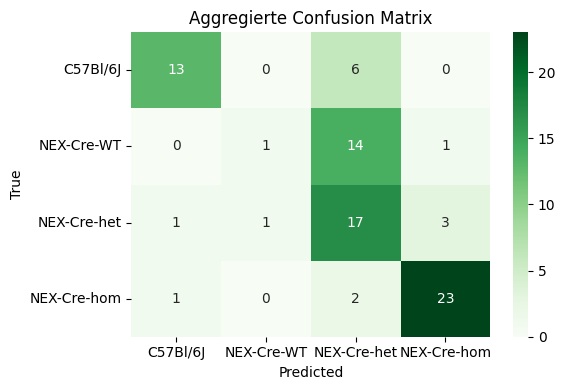


📦 Trainiere finales Modell auf gesamten Daten...

📈 Confusion Matrix (gesamter Datensatz):
 [[16  1  2  0]
 [ 0 10  6  0]
 [ 0  0 21  1]
 [ 0  0  0 26]]

📄 Klassifikationsbericht (gesamter Datensatz):
              precision    recall  f1-score   support

    C57Bl/6J       1.00      0.84      0.91        19
  NEX-Cre-WT       0.91      0.62      0.74        16
 NEX-Cre-het       0.72      0.95      0.82        22
 NEX-Cre-hom       0.96      1.00      0.98        26

    accuracy                           0.88        83
   macro avg       0.90      0.86      0.86        83
weighted avg       0.90      0.88      0.88        83



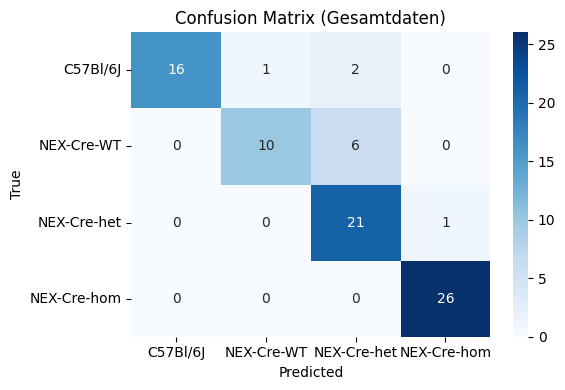

In [ ]:
# load data
df = pd.read_csv("/Users/mass/Documents/Dokumente - mass MacBook Air/W2-Bremen/Github/PCA/endlich.csv")

# Modellparameter
model_params = {
    'C': 1,
    'kernel': 'rbf',
    'gamma': 'scale',
    'class_weight': None
}

# start analysis
final_model, y_true, X_scaled, feature_names, train_accs, val_accs, X_train_df, X_test_df = svm_cv_with_cpu_shap_and_svg(
    df, target_column='Genotype', model_params=model_params
)


Binominaltest and Chance rate

In [ ]:
from scipy.stats import binomtest
import numpy as np

# prediction all data
y_pred = final_model.predict(X_scaled)

# Modell accuracy
mean_accuracy = np.mean(y_pred == y_true)
print(f"📊 Modellgenauigkeit: {mean_accuracy:.4f}")

# most frequent class (Chance Level)
unique, counts = np.unique(y_true, return_counts=True)
most_frequent_class = unique[np.argmax(counts)]
chance_rate = np.mean(y_true == most_frequent_class)
print(f"🎲 Häufigste Klasse: {most_frequent_class}")
print(f"🎯 Chance Rate (Baseline): {chance_rate:.4f}")

# Binomialtest
n = len(y_true)
k = int(mean_accuracy * n)
binom_result = binomtest(k, n, p=chance_rate, alternative='greater')

print(f"\n🧪 Binomialtest p-Wert: {binom_result.pvalue:.4f}")
if binom_result.pvalue < 0.05:
    print("✅ Das Modell liegt signifikant über der Zufallsrate (above chance).")
else:
    print("❌ Das Modell liegt nicht signifikant über der Zufallsrate.")


Accuracy and main features

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shap import KernelExplainer
import shap

model = final_model

# SHAP Feature Importance 
print("📊 Panel B – SHAP Feature Ranking pro Klasse:")

shap_feature_rankings = {}

for i, class_name in enumerate(model.classes_):
    explainer = KernelExplainer(lambda x: model.predict_proba(x)[:, i], X_train_df)
    shap_vals = explainer.shap_values(X_test_df)
    mean_abs = np.abs(shap_vals).mean(axis=0)

    ranking_df = pd.DataFrame({
        'Feature': X_test_df.columns,
        'mean(|SHAP|)': mean_abs
    }).sort_values(by='mean(|SHAP|)', ascending=False)

    shap_feature_rankings[class_name] = ranking_df

    print(f"\n🔹 Klasse: {class_name}")
    display(ranking_df.head(10))  # nur Top 10 anzeigen

#  Training vs. Validation Accuracy 
print("\n📈 Panel C – Training vs. Validation Accuracy (Cross-Validation)")

folds = np.arange(1, len(train_accs) + 1)
plt.figure(figsize=(6, 4))
plt.plot(folds, train_accs, marker='o', label='Training Accuracy')
plt.plot(folds, val_accs, marker='o', label='Validation Accuracy')
plt.title("Training vs. Validation Accuracy (Cross-Validation)")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("panel_c_train_val_accuracy.svg", format="svg")
plt.show()
